In [1]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [3]:
def model(t_u, w, b):
    return w * t_u + b

In [4]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [5]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [6]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

In [7]:
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2, 1, 1)
print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"        z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


In [7]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

In [8]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

In [9]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

In [10]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # <1>
    return dsq_diffs

In [12]:
def dmodel_dw(t_u, w, b):
    return t_u

In [13]:
def dmodel_db(t_u, w, b):
    return 1.0

In [14]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])  # <1>

In [22]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        print('------')
        print('Epoch %d, Loss %f, ' % (epoch, float(loss))) # <3>
        print('Params: ', params)
        print('Grad: ', grad)
        print('------')
            
    return params

In [16]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [23]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

------
Epoch 1, Loss 1763.884766, 
Params:  tensor([-44.1730,  -0.8260])
Grad:  tensor([4517.2964,   82.6000])
------
------
Epoch 2, Loss 5802484.500000, 
Params:  tensor([2568.4011,   45.1637])
Grad:  tensor([-261257.4062,   -4598.9702])
------
------
Epoch 3, Loss 19408029696.000000, 
Params:  tensor([-148527.7344,   -2616.3931])
Grad:  tensor([15109614.0000,   266155.6875])
------
------
Epoch 4, Loss 64915905708032.000000, 
Params:  tensor([8589999.0000,  151310.8906])
Grad:  tensor([-8.7385e+08, -1.5393e+07])
------
------
Epoch 5, Loss 217130525461053440.000000, 
Params:  tensor([-4.9680e+08, -8.7510e+06])
Grad:  tensor([5.0539e+10, 8.9023e+08])
------
------
Epoch 6, Loss 726257583152928129024.000000, 
Params:  tensor([2.8732e+10, 5.0610e+08])
Grad:  tensor([-2.9229e+12, -5.1486e+10])
------
------
Epoch 7, Loss 2429183416467662896627712.000000, 
Params:  tensor([-1.6617e+12, -2.9270e+10])
Grad:  tensor([1.6904e+14, 2.9776e+12])
------
------
Epoch 8, Loss 812512254961173143205

tensor([nan, nan])

In [25]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

------
Epoch 1, Loss 1763.884766, 
Params:  tensor([ 0.5483, -0.0083])
Grad:  tensor([4517.2964,   82.6000])
------
------
Epoch 2, Loss 323.090515, 
Params:  tensor([ 0.3623, -0.0118])
Grad:  tensor([1859.5493,   35.7843])
------
------
Epoch 3, Loss 78.929634, 
Params:  tensor([ 0.2858, -0.0135])
Grad:  tensor([765.4666,  16.5122])
------
------
Epoch 4, Loss 37.552845, 
Params:  tensor([ 0.2543, -0.0143])
Grad:  tensor([315.0790,   8.5787])
------
------
Epoch 5, Loss 30.540283, 
Params:  tensor([ 0.2413, -0.0149])
Grad:  tensor([129.6733,   5.3127])
------
------
Epoch 6, Loss 29.351154, 
Params:  tensor([ 0.2360, -0.0153])
Grad:  tensor([53.3495,  3.9682])
------
------
Epoch 7, Loss 29.148884, 
Params:  tensor([ 0.2338, -0.0156])
Grad:  tensor([21.9304,  3.4148])
------
------
Epoch 8, Loss 29.113848, 
Params:  tensor([ 0.2329, -0.0159])
Grad:  tensor([8.9964, 3.1869])
------
------
Epoch 9, Loss 29.107145, 
Params:  tensor([ 0.2325, -0.0162])
Grad:  tensor([3.6721, 3.0930])
----

tensor([ 0.2327, -0.0438])

In [26]:
t_un = 0.1 * t_u
t_un

tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800,
        4.8400, 6.0400, 6.8400])

In [27]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, # <1>
    t_c = t_c)

------
Epoch 1, Loss 80.364342, 
Params:  tensor([1.7761, 0.1064])
Grad:  tensor([-77.6140, -10.6400])
------
------
Epoch 2, Loss 37.574913, 
Params:  tensor([2.0848, 0.1303])
Grad:  tensor([-30.8623,  -2.3864])
------
------
Epoch 3, Loss 30.871077, 
Params:  tensor([2.2094, 0.1217])
Grad:  tensor([-12.4631,   0.8587])
------
------
Epoch 4, Loss 29.756193, 
Params:  tensor([2.2616, 0.1004])
Grad:  tensor([-5.2218,  2.1327])
------
------
Epoch 5, Loss 29.507153, 
Params:  tensor([2.2853, 0.0740])
Grad:  tensor([-2.3715,  2.6310])
------
------
Epoch 6, Loss 29.392456, 
Params:  tensor([2.2978, 0.0458])
Grad:  tensor([-1.2492,  2.8241])
------
------
Epoch 7, Loss 29.298828, 
Params:  tensor([2.3059, 0.0168])
Grad:  tensor([-0.8071,  2.8970])
------
------
Epoch 8, Loss 29.208717, 
Params:  tensor([ 2.3122, -0.0124])
Grad:  tensor([-0.6325,  2.9227])
------
------
Epoch 9, Loss 29.119415, 
Params:  tensor([ 2.3178, -0.0417])
Grad:  tensor([-0.5633,  2.9298])
------
------
Epoch 10, L

tensor([ 2.7553, -2.5162])

In [29]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c,
#     print_params = False
)

params

------
Epoch 1, Loss 80.364342, 
Params:  tensor([1.7761, 0.1064])
Grad:  tensor([-77.6140, -10.6400])
------
------
Epoch 2, Loss 37.574913, 
Params:  tensor([2.0848, 0.1303])
Grad:  tensor([-30.8623,  -2.3864])
------
------
Epoch 3, Loss 30.871077, 
Params:  tensor([2.2094, 0.1217])
Grad:  tensor([-12.4631,   0.8587])
------
------
Epoch 4, Loss 29.756193, 
Params:  tensor([2.2616, 0.1004])
Grad:  tensor([-5.2218,  2.1327])
------
------
Epoch 5, Loss 29.507153, 
Params:  tensor([2.2853, 0.0740])
Grad:  tensor([-2.3715,  2.6310])
------
------
Epoch 6, Loss 29.392456, 
Params:  tensor([2.2978, 0.0458])
Grad:  tensor([-1.2492,  2.8241])
------
------
Epoch 7, Loss 29.298828, 
Params:  tensor([2.3059, 0.0168])
Grad:  tensor([-0.8071,  2.8970])
------
------
Epoch 8, Loss 29.208717, 
Params:  tensor([ 2.3122, -0.0124])
Grad:  tensor([-0.6325,  2.9227])
------
------
Epoch 9, Loss 29.119415, 
Params:  tensor([ 2.3178, -0.0417])
Grad:  tensor([-0.5633,  2.9298])
------
------
Epoch 10, L

------
Epoch 516, Loss 7.598925, 
Params:  tensor([  4.0798, -10.0143])
Grad:  tensor([-0.2192,  1.2406])
------
------
Epoch 517, Loss 7.583069, 
Params:  tensor([  4.0820, -10.0267])
Grad:  tensor([-0.2188,  1.2385])
------
------
Epoch 518, Loss 7.567265, 
Params:  tensor([  4.0842, -10.0391])
Grad:  tensor([-0.2184,  1.2364])
------
------
Epoch 519, Loss 7.551515, 
Params:  tensor([  4.0864, -10.0514])
Grad:  tensor([-0.2180,  1.2343])
------
------
Epoch 520, Loss 7.535818, 
Params:  tensor([  4.0886, -10.0637])
Grad:  tensor([-0.2177,  1.2322])
------
------
Epoch 521, Loss 7.520176, 
Params:  tensor([  4.0907, -10.0760])
Grad:  tensor([-0.2173,  1.2301])
------
------
Epoch 522, Loss 7.504587, 
Params:  tensor([  4.0929, -10.0883])
Grad:  tensor([-0.2169,  1.2280])
------
------
Epoch 523, Loss 7.489048, 
Params:  tensor([  4.0951, -10.1006])
Grad:  tensor([-0.2165,  1.2259])
------
------
Epoch 524, Loss 7.473566, 
Params:  tensor([  4.0972, -10.1128])
Grad:  tensor([-0.2162, 

------
Epoch 1109, Loss 3.549524, 
Params:  tensor([  4.8978, -14.6447])
Grad:  tensor([-0.0799,  0.4527])
------
------
Epoch 1110, Loss 3.547411, 
Params:  tensor([  4.8986, -14.6493])
Grad:  tensor([-0.0798,  0.4519])
------
------
Epoch 1111, Loss 3.545309, 
Params:  tensor([  4.8994, -14.6538])
Grad:  tensor([-0.0797,  0.4511])
------
------
Epoch 1112, Loss 3.543211, 
Params:  tensor([  4.9002, -14.6583])
Grad:  tensor([-0.0796,  0.4503])
------
------
Epoch 1113, Loss 3.541124, 
Params:  tensor([  4.9010, -14.6628])
Grad:  tensor([-0.0794,  0.4496])
------
------
Epoch 1114, Loss 3.539041, 
Params:  tensor([  4.9018, -14.6673])
Grad:  tensor([-0.0793,  0.4488])
------
------
Epoch 1115, Loss 3.536967, 
Params:  tensor([  4.9026, -14.6717])
Grad:  tensor([-0.0791,  0.4481])
------
------
Epoch 1116, Loss 3.534896, 
Params:  tensor([  4.9034, -14.6762])
Grad:  tensor([-0.0790,  0.4473])
------
------
Epoch 1117, Loss 3.532835, 
Params:  tensor([  4.9042, -14.6807])
Grad:  tensor([

Grad:  tensor([-0.0341,  0.1928])
------
------
Epoch 1612, Loss 3.040077, 
Params:  tensor([  5.1679, -16.1737])
Grad:  tensor([-0.0340,  0.1925])
------
------
Epoch 1613, Loss 3.039695, 
Params:  tensor([  5.1683, -16.1757])
Grad:  tensor([-0.0339,  0.1921])
------
------
Epoch 1614, Loss 3.039314, 
Params:  tensor([  5.1686, -16.1776])
Grad:  tensor([-0.0339,  0.1918])
------
------
Epoch 1615, Loss 3.038934, 
Params:  tensor([  5.1689, -16.1795])
Grad:  tensor([-0.0338,  0.1915])
------
------
Epoch 1616, Loss 3.038557, 
Params:  tensor([  5.1693, -16.1814])
Grad:  tensor([-0.0338,  0.1912])
------
------
Epoch 1617, Loss 3.038181, 
Params:  tensor([  5.1696, -16.1833])
Grad:  tensor([-0.0337,  0.1908])
------
------
Epoch 1618, Loss 3.037805, 
Params:  tensor([  5.1699, -16.1852])
Grad:  tensor([-0.0337,  0.1905])
------
------
Epoch 1619, Loss 3.037432, 
Params:  tensor([  5.1703, -16.1871])
Grad:  tensor([-0.0336,  0.1902])
------
------
Epoch 1620, Loss 3.037059, 
Params:  ten

------
Epoch 2188, Loss 2.943503, 
Params:  tensor([  5.2927, -16.8800])
Grad:  tensor([-0.0128,  0.0723])
------
------
Epoch 2189, Loss 2.943451, 
Params:  tensor([  5.2928, -16.8807])
Grad:  tensor([-0.0127,  0.0722])
------
------
Epoch 2190, Loss 2.943395, 
Params:  tensor([  5.2929, -16.8815])
Grad:  tensor([-0.0127,  0.0720])
------
------
Epoch 2191, Loss 2.943343, 
Params:  tensor([  5.2931, -16.8822])
Grad:  tensor([-0.0127,  0.0719])
------
------
Epoch 2192, Loss 2.943290, 
Params:  tensor([  5.2932, -16.8829])
Grad:  tensor([-0.0127,  0.0718])
------
------
Epoch 2193, Loss 2.943235, 
Params:  tensor([  5.2933, -16.8836])
Grad:  tensor([-0.0127,  0.0717])
------
------
Epoch 2194, Loss 2.943183, 
Params:  tensor([  5.2934, -16.8843])
Grad:  tensor([-0.0126,  0.0715])
------
------
Epoch 2195, Loss 2.943130, 
Params:  tensor([  5.2936, -16.8850])
Grad:  tensor([-0.0126,  0.0714])
------
------
Epoch 2196, Loss 2.943079, 
Params:  tensor([  5.2937, -16.8857])
Grad:  tensor([

Grad:  tensor([-0.0047,  0.0262])
------
------
Epoch 2786, Loss 2.929722, 
Params:  tensor([  5.3406, -17.1511])
Grad:  tensor([-0.0046,  0.0262])
------
------
Epoch 2787, Loss 2.929714, 
Params:  tensor([  5.3406, -17.1514])
Grad:  tensor([-0.0046,  0.0261])
------
------
Epoch 2788, Loss 2.929707, 
Params:  tensor([  5.3407, -17.1516])
Grad:  tensor([-0.0046,  0.0261])
------
------
Epoch 2789, Loss 2.929701, 
Params:  tensor([  5.3407, -17.1519])
Grad:  tensor([-0.0046,  0.0260])
------
------
Epoch 2790, Loss 2.929692, 
Params:  tensor([  5.3408, -17.1522])
Grad:  tensor([-0.0046,  0.0260])
------
------
Epoch 2791, Loss 2.929685, 
Params:  tensor([  5.3408, -17.1524])
Grad:  tensor([-0.0046,  0.0259])
------
------
Epoch 2792, Loss 2.929681, 
Params:  tensor([  5.3408, -17.1527])
Grad:  tensor([-0.0046,  0.0259])
------
------
Epoch 2793, Loss 2.929672, 
Params:  tensor([  5.3409, -17.1529])
Grad:  tensor([-0.0046,  0.0258])
------
------
Epoch 2794, Loss 2.929666, 
Params:  ten

------
Epoch 3257, Loss 2.928065, 
Params:  tensor([  5.3555, -17.2358])
Grad:  tensor([-0.0021,  0.0117])
------
------
Epoch 3258, Loss 2.928064, 
Params:  tensor([  5.3555, -17.2359])
Grad:  tensor([-0.0021,  0.0117])
------
------
Epoch 3259, Loss 2.928061, 
Params:  tensor([  5.3556, -17.2360])
Grad:  tensor([-0.0021,  0.0117])
------
------
Epoch 3260, Loss 2.928060, 
Params:  tensor([  5.3556, -17.2361])
Grad:  tensor([-0.0021,  0.0117])
------
------
Epoch 3261, Loss 2.928057, 
Params:  tensor([  5.3556, -17.2362])
Grad:  tensor([-0.0021,  0.0117])
------
------
Epoch 3262, Loss 2.928058, 
Params:  tensor([  5.3556, -17.2364])
Grad:  tensor([-0.0021,  0.0116])
------
------
Epoch 3263, Loss 2.928056, 
Params:  tensor([  5.3557, -17.2365])
Grad:  tensor([-0.0021,  0.0116])
------
------
Epoch 3264, Loss 2.928055, 
Params:  tensor([  5.3557, -17.2366])
Grad:  tensor([-0.0021,  0.0116])
------
------
Epoch 3265, Loss 2.928052, 
Params:  tensor([  5.3557, -17.2367])
Grad:  tensor([

Grad:  tensor([-0.0007,  0.0043])
------
------
Epoch 3853, Loss 2.927700, 
Params:  tensor([  5.3633, -17.2797])
Grad:  tensor([-0.0007,  0.0043])
------
------
Epoch 3854, Loss 2.927701, 
Params:  tensor([  5.3633, -17.2798])
Grad:  tensor([-0.0007,  0.0043])
------
------
Epoch 3855, Loss 2.927701, 
Params:  tensor([  5.3633, -17.2798])
Grad:  tensor([-0.0007,  0.0043])
------
------
Epoch 3856, Loss 2.927700, 
Params:  tensor([  5.3633, -17.2799])
Grad:  tensor([-0.0007,  0.0042])
------
------
Epoch 3857, Loss 2.927700, 
Params:  tensor([  5.3633, -17.2799])
Grad:  tensor([-0.0007,  0.0042])
------
------
Epoch 3858, Loss 2.927700, 
Params:  tensor([  5.3633, -17.2799])
Grad:  tensor([-0.0007,  0.0042])
------
------
Epoch 3859, Loss 2.927701, 
Params:  tensor([  5.3633, -17.2800])
Grad:  tensor([-0.0007,  0.0042])
------
------
Epoch 3860, Loss 2.927699, 
Params:  tensor([  5.3633, -17.2800])
Grad:  tensor([-0.0008,  0.0042])
------
------
Epoch 3861, Loss 2.927699, 
Params:  ten

Params:  tensor([  5.3661, -17.2955])
Grad:  tensor([-0.0003,  0.0016])
------
------
Epoch 4439, Loss 2.927654, 
Params:  tensor([  5.3661, -17.2955])
Grad:  tensor([-0.0003,  0.0016])
------
------
Epoch 4440, Loss 2.927654, 
Params:  tensor([  5.3661, -17.2955])
Grad:  tensor([-0.0003,  0.0016])
------
------
Epoch 4441, Loss 2.927654, 
Params:  tensor([  5.3661, -17.2955])
Grad:  tensor([-0.0003,  0.0016])
------
------
Epoch 4442, Loss 2.927653, 
Params:  tensor([  5.3661, -17.2956])
Grad:  tensor([-0.0003,  0.0016])
------
------
Epoch 4443, Loss 2.927653, 
Params:  tensor([  5.3661, -17.2956])
Grad:  tensor([-0.0002,  0.0016])
------
------
Epoch 4444, Loss 2.927653, 
Params:  tensor([  5.3661, -17.2956])
Grad:  tensor([-0.0003,  0.0016])
------
------
Epoch 4445, Loss 2.927653, 
Params:  tensor([  5.3661, -17.2956])
Grad:  tensor([-0.0003,  0.0016])
------
------
Epoch 4446, Loss 2.927654, 
Params:  tensor([  5.3661, -17.2956])
Grad:  tensor([-0.0003,  0.0016])
------
------
Ep

tensor([  5.3671, -17.3012])

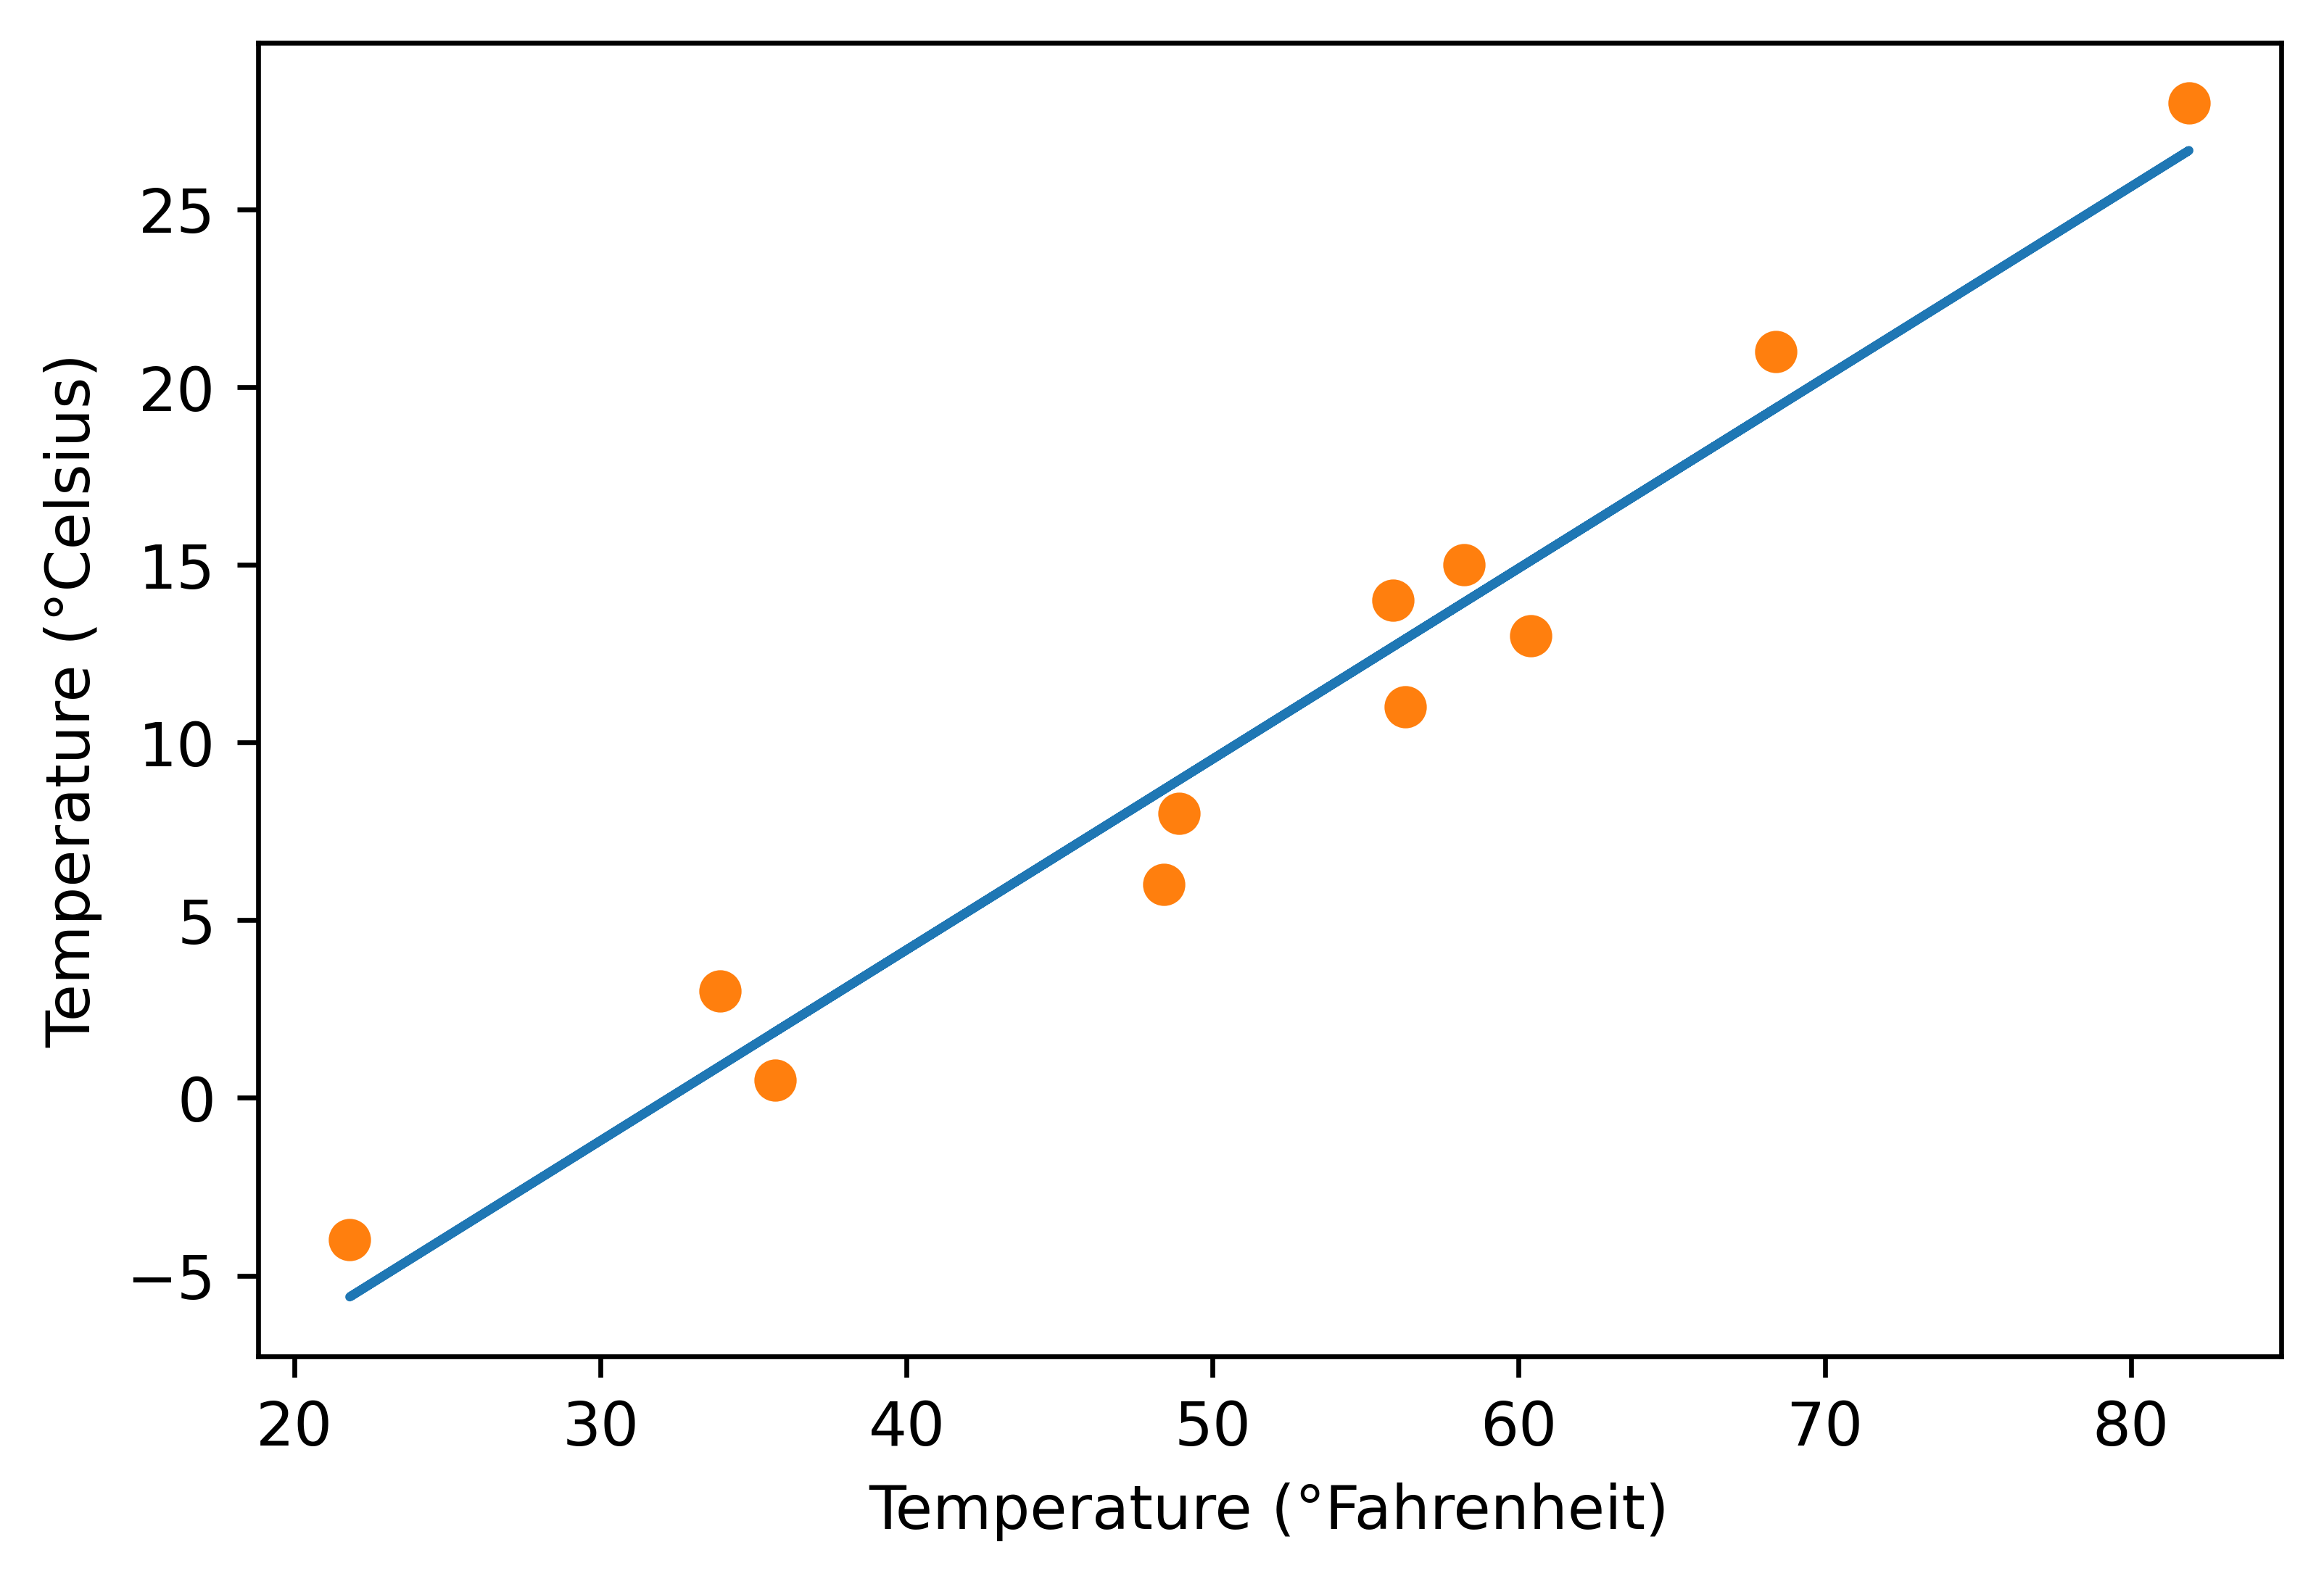

In [32]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

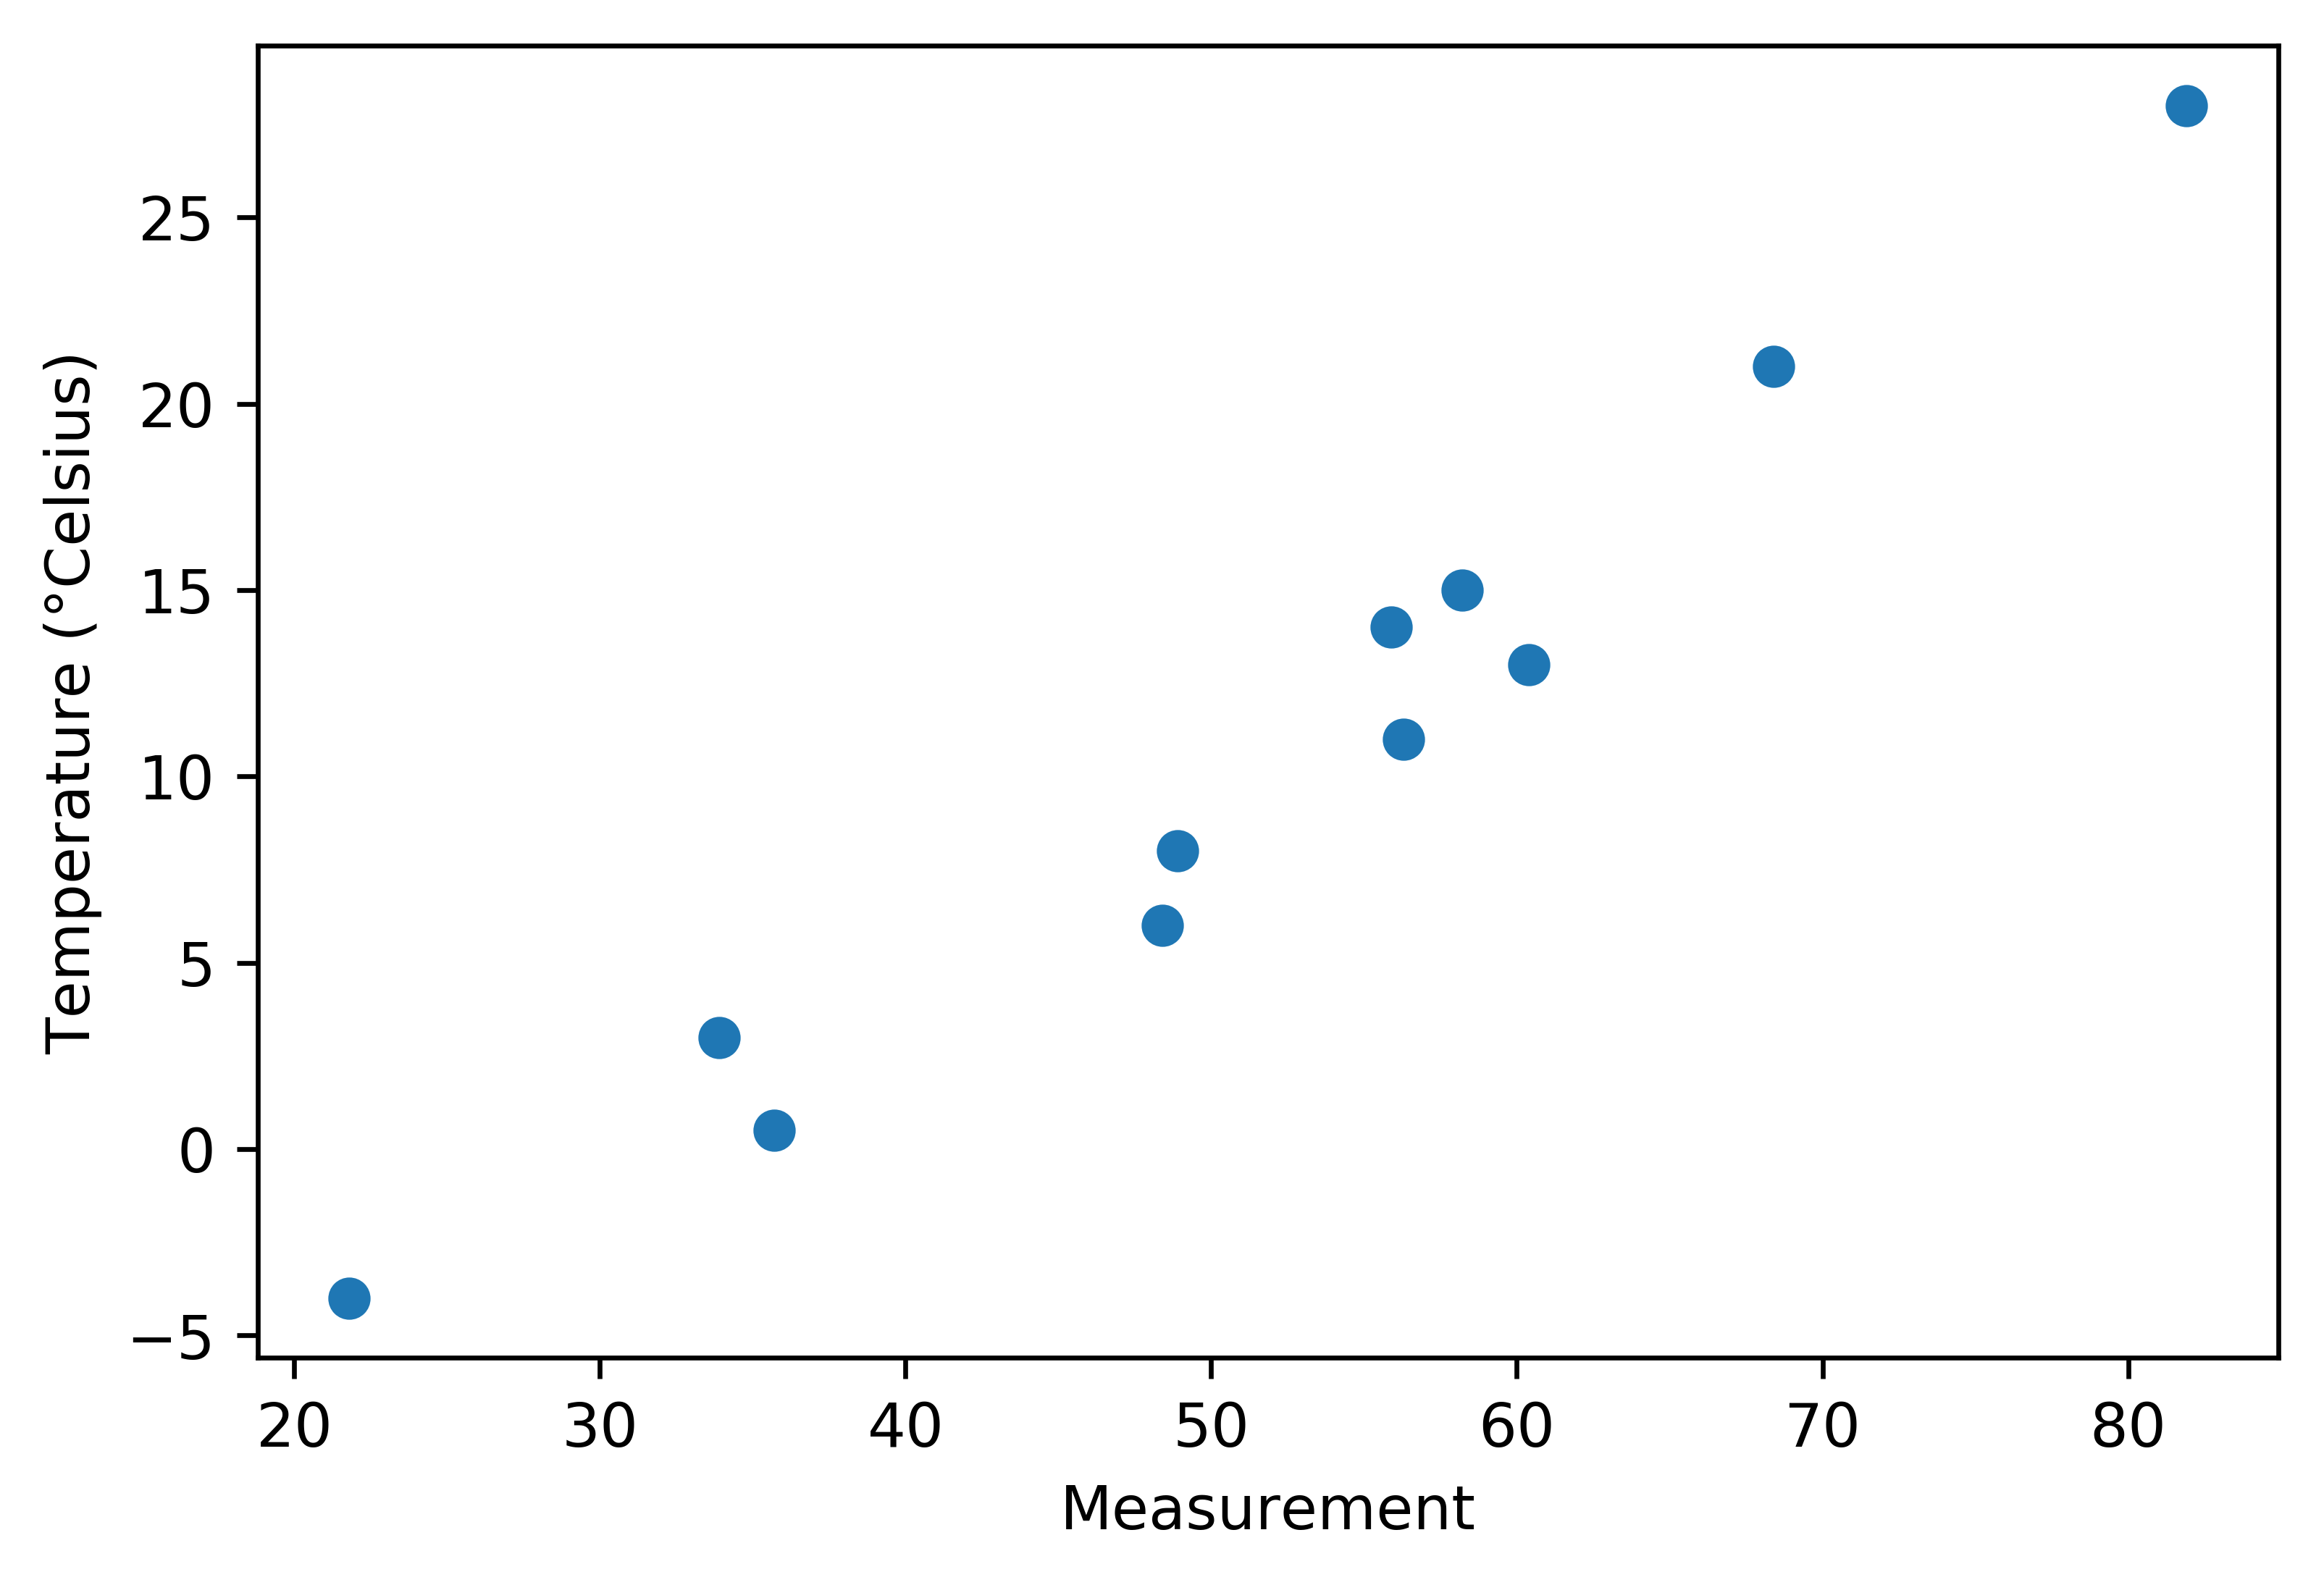

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(dpi=600)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

plt.savefig("temp_data_plot.png", format="png")

In [37]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [43]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
            
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():
            params -= learning_rate * params.grad
            
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [45]:
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [46]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f ' % (epoch, float(loss)))
            
    return params

In [49]:
import torch.optim as optim
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

In [52]:
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 2.927645 
Epoch 1000, Loss 2.927645 
Epoch 1500, Loss 2.927645 
Epoch 2000, Loss 2.927645 
Epoch 2500, Loss 2.927645 
Epoch 3000, Loss 2.927645 
Epoch 3500, Loss 2.927645 
Epoch 4000, Loss 2.927645 
Epoch 4500, Loss 2.927645 
Epoch 5000, Loss 2.927645 


tensor([  5.3676, -17.3042], requires_grad=True)

In [54]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

In [57]:
training_loop(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params,
    t_u = t_u,
    t_c = t_c)

Epoch 500, Loss 2.927646 
Epoch 1000, Loss 2.927645 
Epoch 1500, Loss 2.927644 
Epoch 2000, Loss 2.927644 


tensor([  0.5368, -17.3048], requires_grad=True)

In [62]:
n_samples = t_u.shape[0]
t_u.shape

torch.Size([11])

In [102]:
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
n_val

2

In [103]:
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

(tensor([ 5, 10,  7,  0,  1,  3,  2,  8,  6]), tensor([9, 4]))

In [104]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

In [105]:
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

In [106]:
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [111]:
def training_loop(n_epochs, optimizer, params, train_t_u,
                  val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
#             print(f'Val_t_p: {val_t_p}, Val_t_c: {val_t_c}')
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
    return params

In [112]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

In [113]:
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 89.6366, Validation loss 38.6392
Epoch 2, Training loss 44.9269, Validation loss 2.5454
Epoch 3, Training loss 37.1240, Validation loss 0.5562
Epoch 500, Training loss 6.6685, Validation loss 5.3562
Epoch 1000, Training loss 2.9650, Validation loss 6.1116
Epoch 1500, Training loss 2.4965, Validation loss 6.4033
Epoch 2000, Training loss 2.4372, Validation loss 6.5099
Epoch 2500, Training loss 2.4297, Validation loss 6.5482
Epoch 3000, Training loss 2.4288, Validation loss 6.5619
Epoch 3500, Training loss 2.4286, Validation loss 6.5667
Epoch 4000, Training loss 2.4286, Validation loss 6.5685
Epoch 4500, Training loss 2.4286, Validation loss 6.5691
Epoch 5000, Training loss 2.4286, Validation loss 6.5693


tensor([  5.4878, -17.4613], requires_grad=True)